## Visualize differential expression outputs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy


# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection

## Read merged DE results

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CRiCD4_Run1_Illumina/'
experiment_name = 'CRiCD4_Run1_Illumina'
obs_df = pd.read_csv(f'{datadir}/{experiment_name}_merged.gex.lognorm.postQC_obs.csv', compression='gzip', index_col=0)

In [5]:
adata_de = sc.read_h5ad(datadir + f'/DE_results/{experiment_name}.merged_DE_results.h5ad')

In [82]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

## On-target effect

In [59]:
all_targets = adata_de.obs['target_contrast'].astype(str).unique()
measured_targets = adata_de.var_names[adata_de.var_names.isin(all_targets)].tolist()

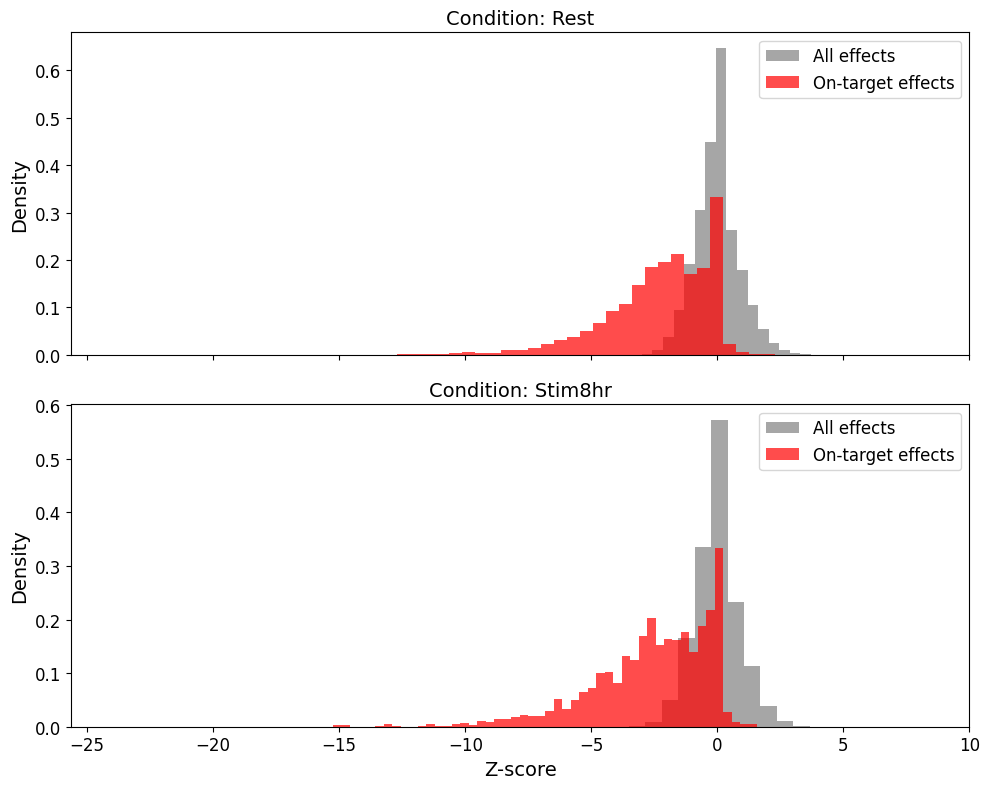

In [84]:
# Get all unique culture conditions
conditions = adata_de.obs['culture_condition'].unique()

# Create a figure with subplots, one for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(10, 4*len(conditions)), sharex=True)

for i, cond in enumerate(conditions):
    # Get on-target effects for this condition
    ontarget_cond = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                  ['target_contrast'] + measured_targets, layer='zscore')
    ontarget_cond = ontarget_cond.set_index('target_contrast').loc[measured_targets]
    
    # Plot histograms with normalized heights (density=True)
    axes[i].hist(adata_de[adata_de.obs['culture_condition'] == cond].layers['zscore'].flatten(), 
                bins=100, density=True, alpha=0.7, color='grey', label='All effects')
    axes[i].hist(np.diag(ontarget_cond.values), bins=50, density=True, alpha=0.7, 
                color='red', label='On-target effects')
    
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(labelsize=12)
    axes[i].legend(fontsize=12)
    axes[i].set_title(f'Condition: {cond}', fontsize=14)
    axes[i].set_xlim(right=10)  # Set upper x-limit to 10

# Set common x-label
plt.xlabel('Z-score', fontsize=14)
plt.tight_layout()


In [22]:
adata_de[adata_de.obs['target_contrast'].isin(measured_targets), measured_targets]

View of AnnData object with n_obs × n_vars = 5544 × 2772
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name', 'mt'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value'